In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant, no prefactor
def f(r,n,re):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,n,re,load=True,path='../')**2 
                    + nf.d_v(r,load=True,path='../')**2)
#keeping others but holding them constant, Using prefactor
def g(r,c):
    return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + c**2*nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,load=True,path='../')**2)
#Only Bulge, no prefactor
def b(r,n,re):
    return nf.b_v(r,n,re,load=True,path='../')
#Only Bulge, Using prefactor
def b2(r,c):
    return c*nf.b_v(r,load=True,path='../')

In [4]:
#Fit, Keeping rest constant, no prefactor

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Bulge Params
l_params.add('n', value=nf.n_c, min=0) 
l_params.add('re', value=nf.re_c, min=0) 
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [5]:
#Fit, Keeping rest constant, Using prefactor

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Bulge Params
g_params.add('c', value=1, min=0)
#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [6]:
#Fit, B Only, no prefactor

#Setup
b_mod = lm.Model(b)
b_params = l_mod.make_params()
#Bulge Params
b_params.add('n', value=nf.n_c, min=0) 
b_params.add('re', value=nf.re_c, min=0) 
#Do fit
b_fit = b_mod.fit(v_dat,b_params,r=r_dat,weights=weighdata)

In [7]:
#Fit, B Only, no prefactor

#Setup
b2_mod = lm.Model(b2,nan_policy='propagate')
b2_params = b2_mod.make_params()
#Bulge Params
b2_params.add('n', value=nf.n_c, min=0) 
b2_params.add('re', value=nf.re_c, min=0) 
#Do fit
b2_fit = b2_mod.fit(v_dat,b2_params,r=r_dat,weights=weighdata)

In [8]:
#Define curves to plot

l_dict = l_fit.best_values
l_n = l_dict['n']
l_re = l_dict['re']
l_curve = f(r_dat,l_n,l_re)

g_dict = g_fit.best_values
g_c = g_dict['c']
g_curve = g(r_dat,g_c)

b_dict = b_fit.best_values
b_n = b_dict['n']
b_re = b_dict['re']

b2_dict = b2_fit.best_values
b2_c = b2_dict['c']

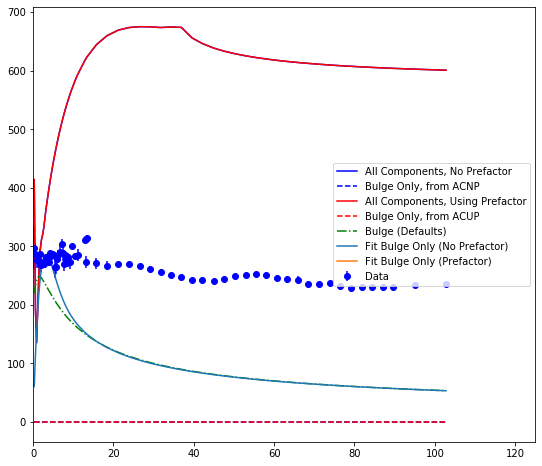

In [9]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, No Prefactor')
plt.plot(r_dat,b(r_dat,l_n,l_re),'b--',label='Bulge Only, from ACNP')
plt.plot(r_dat,g_curve,'r-',label='All Components, Using Prefactor')
plt.plot(r_dat,b2(r_dat,g_c),'r--',label='Bulge Only, from ACUP')
plt.plot(r_dat,nf.b_v(r_dat,load=True,path='../'),'g-.',label='Bulge (Defaults)')
plt.plot(r_dat,b(r_dat,b_n,b_re),label='Fit Bulge Only (No Prefactor)')
plt.plot(r_dat,b2(r_dat,b2_c),label='Fit Bulge Only (Prefactor)')

plt.legend()
plt.show()

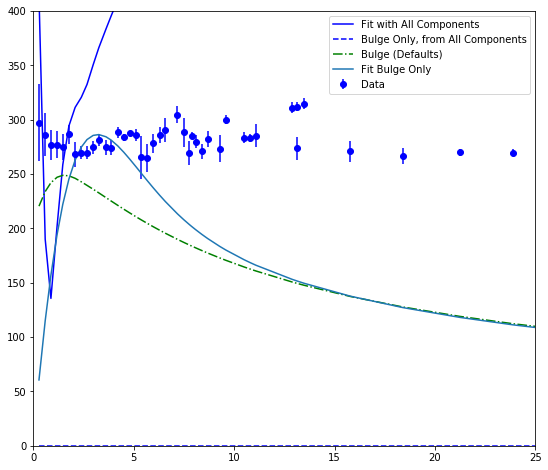

In [10]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='Fit with All Components')
plt.plot(r_dat,nf.b_v(r_dat,l_n,l_re,load=True,path='../'),'b--',label='Bulge Only, from All Components')
plt.plot(r_dat,nf.b_v(r_dat,load=True,path='../'),'g-.',label='Bulge (Defaults)')
plt.plot(r_dat,nf.b_v(r_dat,b_n,b_re,load=True,path='../'),label='Fit Bulge Only')

plt.legend()
plt.show()

In [11]:
print('Fit information for all-component fit, no prefactor:')
l_fit

Fit information for all-component fit, no prefactor:


In [12]:
print('Fit information for all-component fit, prefactor:')
g_fit

Fit information for all-component fit, prefactor:


In [13]:
print('Fit information for single-component fit, no prefactor:')
b_fit

Fit information for single-component fit, no prefactor:


In [14]:
print('Fit information for single-component fit, prefactor:')
b2_fit

Fit information for single-component fit, prefactor:


In [15]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total time:
465.9223928451538 seconds

Timestamp:
2019-10-11 11:55:35.607855
